# Causal Data Augmentation notebook
In this notebook we provide a step-by-step guide to perform Causal Data Augmentation using our API
## Load the dataset
We load the dataset in csv or xlsx format using pandas

In [63]:
import pandas as pd

target_countries = ['Senegal', 'Mauritania', 'Mali', 'Burkina Faso', 'Niger', 'Nigeria', 'Cameroon', 'Chad', 'Central African Republic', 'South Sudan', 'Sudan', 'Eritrea']

dataset = pd.read_excel('datasets/Dataset_Monthly_World.xlsx').dropna()
# dataset = pd.read_csv('datasets/DatasetMonthly.csv')
dataset = dataset.rename(columns={'country': 'COUNTRY', 'date': 'EVENT_DATE', 'Fatalities': 'FATALITIES', 'Political Stability & Absence of Violence': 'Political Stability and Absence of Violence/Terrorism: Estimate'})

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16092 entries, 0 to 20046
Data columns (total 17 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   COUNTRY                                                          16092 non-null  object        
 1   EVENT_DATE                                                       16092 non-null  datetime64[ns]
 2   FATALITIES                                                       16092 non-null  int64         
 3   Demonstrations                                                   16092 non-null  int64         
 4   Political violence                                               16092 non-null  int64         
 5   Strategic developments                                           16092 non-null  int64         
 6   Control of Corruption                                            16092 non-null  fl

We filter for data in the Sahel region

In [64]:
dataset = dataset.loc[dataset['COUNTRY'].isin(target_countries)]

## Create the lagged variables
To create the lagged variables we use pandas, we choose to simply shift the fatalities

In [65]:
import numpy as np

country_list = dataset['COUNTRY'].unique()
results = []
results_original = []
window_length = 6 # months, modify as needed


dataset['FATALITIES'] = dataset['FATALITIES'].astype(float)
for country in np.unique(dataset['COUNTRY']):
    for lag in range(1, window_length+1):
        dataset.loc[dataset['COUNTRY']==country, f'FATALITIES_lag{lag}'] = dataset.loc[dataset['COUNTRY']==country, 'FATALITIES'].shift(lag).fillna(0)

## Splitting the dataset
For CDA, we need to create the datasets for every domain we want to shift to. In our case we split the dataset into two domains: one for peaceful scenarios, one for troubled scenarios. However, first we need to split in train, test and validation to avoid data leakage.

In [66]:
from sklearn.model_selection import train_test_split

target = 'FATALITIES'

if 'MY' in dataset.columns:
    time_col = 'MY'
if 'EVENT_DATE' in dataset.columns:
    time_col = 'EVENT_DATE'

train_data = []
test_data = []
val_data = []

for cid, country in enumerate(target_countries):
    data = dataset.loc[dataset['COUNTRY'] == country].copy()
    data = data.sort_values(by=time_col)
    data = data.ffill().bfill()
    
    train, test = train_test_split(data, test_size=0.40, shuffle=False)
    val, test = train_test_split(test, test_size=0.50, shuffle=False)

    train_data.append(train)
    test_data.append(test)
    val_data.append(val)

pd.concat(train_data).to_csv('datasets/train.csv', index=False)
pd.concat(test_data).to_csv('datasets/test.csv', index=False)
pd.concat(val_data).to_csv('datasets/val.csv', index=False)

## Creating the domain datasets
We create the domain datasets using only training data, we also create the causal graph

In [67]:
from lingam import DirectLiNGAM
import networkx as nx

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)
val_data = pd.concat(val_data)

causal_model = DirectLiNGAM()
causal_model.fit(train_data.drop(columns=['COUNTRY', time_col], axis=1))
causal_graph = nx.DiGraph(causal_model.adjacency_matrix_)

mask1 = train_data['Political Stability and Absence of Violence/Terrorism: Estimate']<0
mask2 = train_data['FATALITIES'] > 50
mask = mask1
peaceful_domain = train_data[~mask]
tumultuous_domain = train_data[mask]

## Creating the augmented datasets with CDA
We create augmented training data by using CDA, shifting each country data two times: one time toward the distribution of the peaceful domain and one towards the distribution of tumultuous domain.

In [68]:
import kernel

train_data_aug = []

for cid, country in enumerate(target_countries):
    
    data = train_data.loc[train_data['COUNTRY'] == country].copy().drop(columns=['COUNTRY', time_col], axis=1)
    data = data.ffill().bfill()

    data_aug_peaceful = kernel.causal_data_augmentation(data, peaceful_domain.dropna().drop(['COUNTRY', time_col], axis=1).copy().sample(500, replace=True), causal_graph, 'FATALITIES')
    data_aug_tumultuous = kernel.causal_data_augmentation(data, tumultuous_domain.dropna().drop(['COUNTRY', time_col], axis=1).copy().sample(500, replace=True), causal_graph, 'FATALITIES')

    data_aug = pd.concat([data, data_aug_peaceful, data_aug_tumultuous], axis=0)
    data_aug = pd.concat([data, data_aug_tumultuous], axis=0)
    data_aug['COUNTRY'] = np.repeat(country, len(data_aug))
    
    for column in data_aug.columns:
        if 'FATALITIES' in column:
            data_aug[column] = np.where(data_aug[column]<0, np.zeros_like(data_aug[column]), data_aug[column])
    
    train_data_aug.append(data_aug)

pd.concat(train_data_aug).to_csv('datasets/train_aug.csv', index=False)
train_data_aug = pd.concat(train_data_aug)

11it [00:06,  1.06it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:20,  1.02it/s]
11it [00:06,  1.03it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:20,  1.03it/s]
21it [00:13,  1.59it/s]
21it [00:13,  1.57it/s]
21it [00:14,  1.42it/s]
21it [00:14,  1.42it/s]
13it [00:05,  1.36it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: overflow encountered in divide
  weights = scores/sum(scores)
21it [00:12,  1.65it/s]
21it [00:12,  1.63it/s]
21it [00:16,  1.30it/s]
21it [00:16,  1.28it/s]
21it [00:25,  1.20s

We can visualise the example of Burkina Faso

In [69]:
from sktime.utils import plot_series

data_burkina = train_data.loc[train_data['COUNTRY'] == 'Burkina Faso'].copy().drop(columns=['COUNTRY', time_col], axis=1)
data_burkina = data_burkina.ffill().bfill()
fatalities_real_burkina = data_burkina['FATALITIES'].reset_index(drop=True)

fatalities_peaceful_burkina = kernel.causal_data_augmentation(data_burkina, peaceful_domain.dropna().drop(['COUNTRY', time_col], axis=1).copy().sample(500, replace=True), causal_graph, 'FATALITIES')['FATALITIES'].clip(lower=0)
fatalities_tumultuous_burkina = kernel.causal_data_augmentation(data_burkina, tumultuous_domain.dropna().drop(['COUNTRY', time_col], axis=1).copy().sample(500, replace=True), causal_graph, 'FATALITIES')['FATALITIES'].clip(lower=0)

fig, ax = plot_series(fatalities_real_burkina, fatalities_peaceful_burkina, fatalities_tumultuous_burkina, labels=('Real series', 'Peaceful series', 'Tumultuous series'), x_label='Months', y_label='Fatalities', title='Causal Data Augmentation in Burkina Faso')
fig.savefig('causal_data_augmentation_burkina.eps', format='eps')

ValueError: Cannot take a larger sample than population when 'replace=False'

## Training models
We can use the augmented dataset to train models for every country. We train models with both the original and the augment datasets and perform a hyperparameter search. We also include the spike precision and spike recall metrics.

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
from metrics import spike_precision, spike_recall
import pandas as pd
import re

scoring='neg_mean_absolute_error' # Change as needed

# Define the models and their respective hyperparameters for GridSearchCV
models = {
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 50],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 50],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(verbose=-1),
        'params': {
            'n_estimators': [100, 200, 50],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [-1, 5, 10]
        }
    }
}

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['Country', 'Data Type', 'Model', 'Best Parameters', 'Best Score'])

model_dict = {}

for cid, country in tqdm(enumerate(target_countries)):
    for model_name, model_info in models.items():
        
        data_original = train_data[train_data['COUNTRY'] == country].copy().drop(columns=['COUNTRY', time_col], axis=1)
        try:
            data_aug = train_data_aug[train_data_aug['COUNTRY'] == country].copy().drop(columns=['COUNTRY', time_col], axis=1)
        except:
            data_aug = train_data_aug[train_data_aug['COUNTRY'] == country].copy().drop(columns=['COUNTRY'], axis=1)


        x_val = val_data[val_data['COUNTRY'] == country].copy().drop(columns=['COUNTRY', time_col], axis=1)
        y_val = x_val[target]
        x_val = x_val.drop(columns=[target], axis=1)

        x_test = test_data[test_data['COUNTRY'] == country].copy().drop(columns=['COUNTRY', time_col], axis=1)
        y_test = x_test[target]
        x_test = x_test.drop(columns=[target], axis=1)

        for data_type, data in zip(['Original', 'Augmented'], [data_original, data_aug]):

            x_train = data.drop(columns=[target], axis=1)
            y_train = data[target]
            
            # Combine the training and validation sets
            X = pd.concat([x_train, x_val])
            y = pd.concat([y_train, y_val])

            # Create a list where train data indices are -1 and validation data indices are 0
            split_index = [-1 if x in x_train.index else 0 for x in X.index]

            # Create a PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)

            # Perform the grid search
            grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=pds, scoring=scoring)
            
            try:
                grid_search.fit(X, y)
            except:
                X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
                x_test = x_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
                grid_search.fit(X, y)

            y_pred = grid_search.predict(x_test).clip(min=0)
            mae = mean_absolute_error(y_test, y_pred)
            spike_prec = spike_precision(y_pred, y_test, 50, 20)
            spike_rec = spike_recall(y_pred, y_test, 50, 20)
            # Store the results
            results_row = pd.DataFrame({
                'Country': [country],
                'Data Type': [data_type],
                'Model': [model_name],
                'Best Parameters': [grid_search.best_params_],
                'Best Score': [grid_search.best_score_],
                'MAE': [mae],
                'Spike precision': spike_prec,
                'Spike recall': spike_rec
            })

            model_dict[f'{country}_{data_type}_{model_name}'] = grid_search.best_estimator_

            results = pd.concat([results, results_row], axis=0, ignore_index=True)

0it [00:00, ?it/s]C:\Users\alber\AppData\Local\Temp\ipykernel_1144\3187139257.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, results_row], axis=0, ignore_index=True)
12it [10:50, 54.23s/it]


In [ ]:
# Save the results to a CSV file
results.to_csv('grid_search_results.csv', index=False)
results.to_latex('grid_search_results.tex', index=False)

Now we can analise the results and see how our techniques performed on average

In [ ]:
results_sahel = results.groupby(['Data Type', 'Model'])[['MAE', 'Spike precision', 'Spike recall']].mean().reset_index()
results_sahel.to_csv('grid_search_results_sahel.csv', index=False)
results_sahel.round(2).to_latex('grid_search_results_sahel.tex', index=False)

print(results_sahel)

   Data Type         Model         MAE  Spike precision  Spike recall
0  Augmented      LightGBM   92.391750         0.374477      0.326448
1  Augmented  RandomForest   90.108111         0.369417      0.326906
2  Augmented       XGBoost   83.597360         0.378968      0.365884
3   Original      LightGBM  104.489246         0.386193      0.270758
4   Original  RandomForest   99.513357         0.359473      0.333548
5   Original       XGBoost   97.727083         0.355668      0.338833


We can also count how many countries took advantage of the augmentation

In [ ]:
# Pivot the DataFrame to get 'Best Score' for 'Augmented' and 'Original' in the same row
pivot = results.pivot_table(index=['Country', 'Model'], columns='Data Type', values='MAE')

# Calculate a new column for whether 'Augmented' did better than 'Original'
pivot['Augmented Better'] = pivot['Augmented'] < pivot['Original']

# Reset the index to turn 'Country' and 'Model' back into columns
pivot = pivot.reset_index()

# Calculate the ratio of the number of countries that did better with 'Augmented' for each model
ratios = pivot.groupby('Model')['Augmented Better'].mean()

ratios.to_latex('grid_search_results_ratios.tex')

print(ratios)

Model
LightGBM        0.500000
RandomForest    0.583333
XGBoost         0.583333
Name: Augmented Better, dtype: float64


We can look at the performance of our model, looking again at Burkina Faso. We can see that it does not perform very well because the domain shift is not targeted towards the specific country.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


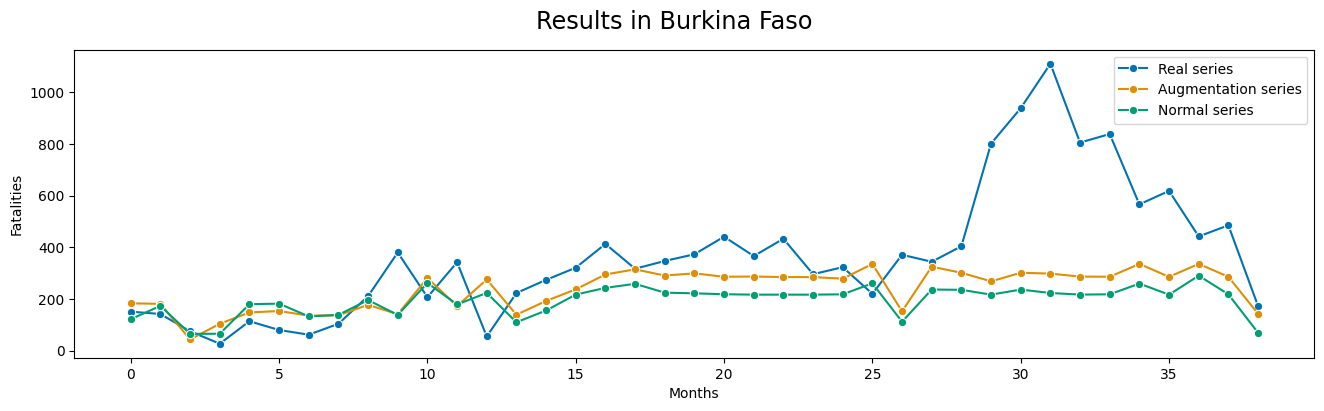

In [ ]:
from matplotlib import pyplot as plt

forecaster_aug = model_dict['Burkina Faso_Augmented_XGBoost']
forecaster_original = model_dict['Burkina Faso_Original_XGBoost']

x_test_burkina = test_data[test_data['COUNTRY'] == 'Burkina Faso'].copy().drop(columns=['COUNTRY', time_col], axis=1)
y_test_burkina = x_test_burkina[target]
x_test_burkina = x_test_burkina.drop(columns=[target], axis=1)

y_pred_burkina_aug = forecaster_aug.predict(x_test_burkina).clip(min=0)
y_pred_burkina_original = forecaster_original.predict(x_test_burkina).clip(min=0)

fig, ax = plot_series(pd.DataFrame(y_test_burkina.values), pd.DataFrame(y_pred_burkina_aug), pd.DataFrame(y_pred_burkina_original), labels=('Real series', 'Augmentation series', 'Normal series'), x_label='Months', y_label='Fatalities', title='Results in Burkina Faso')
fig.savefig('results_burkina.eps', format='eps')

## Calibration
For calibrating the models we show again the example of Burkina Faso. Showing how it can beneficial to augment also the calibration set. As a calibration set we use the validation set we used before.

0it [00:00, ?it/s]

5it [00:00, 41.94it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
20it [00:01, 12.86it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:01, 15.49it/s]
5it [00:00, 43.37it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:01, 16.83it/s]
The PostScript backend does not support transparency; partially transpare

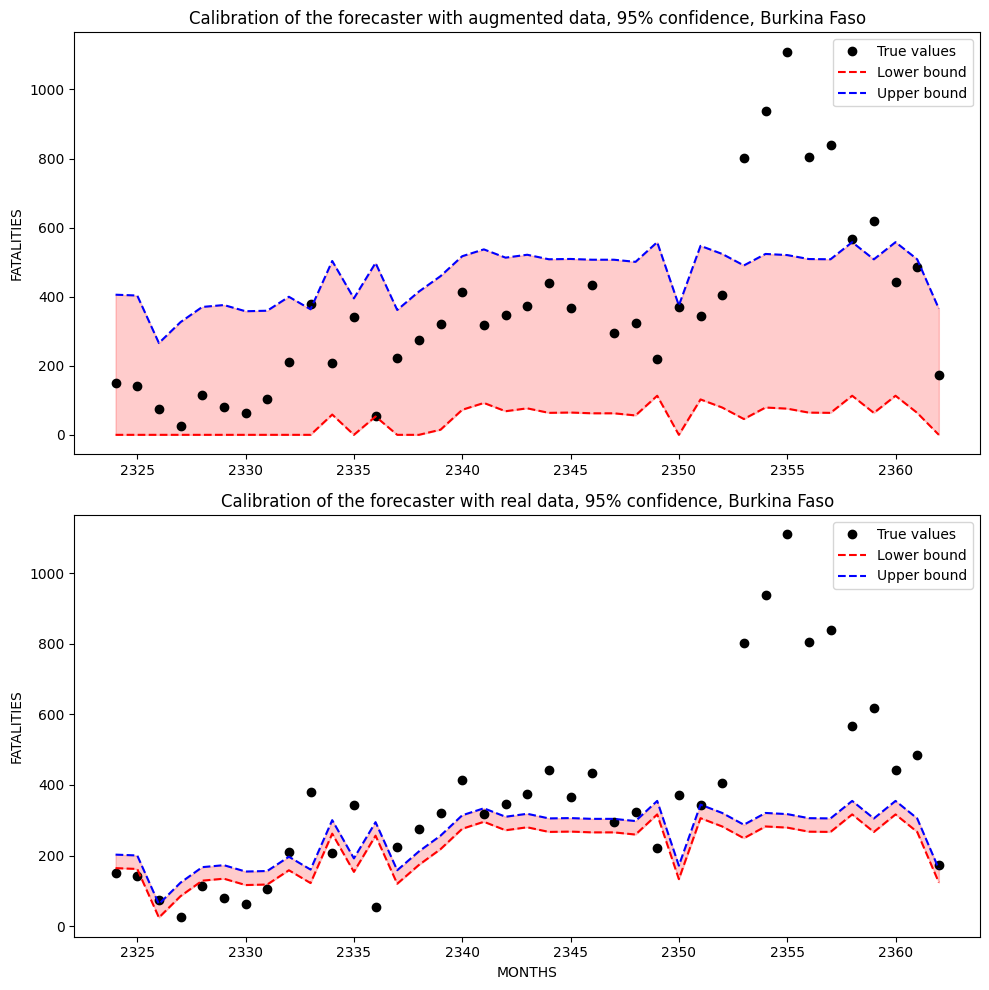

In [ ]:
from nonconformist.cp import IcpRegressor
from nonconformist.nc import RegressorNc, AbsErrorErrFunc
from matplotlib import pyplot as plt

forecaster = model_dict['Burkina Faso_Augmented_XGBoost']

data_burkina_cal = val_data.loc[val_data['COUNTRY'] == 'Burkina Faso'].copy().drop(columns=['COUNTRY', time_col], axis=1).ffill().bfill()
data_burkina_test = test_data.loc[test_data['COUNTRY'] == 'Burkina Faso'].copy().drop(columns=['COUNTRY', time_col], axis=1).ffill().bfill()

data_burkina_cal_aug_peaceful = kernel.causal_data_augmentation(data_burkina_cal, peaceful_domain.dropna().drop(['COUNTRY', time_col], axis=1).copy().sample(200), causal_graph, 'FATALITIES')
data_burkina_cal_aug_tumultuous = kernel.causal_data_augmentation(data_burkina_cal, tumultuous_domain.dropna().drop(['COUNTRY', time_col], axis=1).copy().sample(200), causal_graph, 'FATALITIES')
data_burkina_cal_aug = pd.concat([data_burkina_cal, data_burkina_cal_aug_peaceful, data_burkina_cal_aug_tumultuous], axis=0)

x_burkina_cal_aug = data_burkina_cal_aug.drop(columns=[target], axis=1)
y_burkina_cal_aug = data_burkina_cal_aug[target]

x_burkina_cal_real = data_burkina_cal.drop(columns=[target], axis=1)
y_burkina_cal_real = data_burkina_cal[target]

x_burkina_test = data_burkina_test.drop(columns=[target], axis=1)
y_burkina_test = data_burkina_test[target]

nc = RegressorNc(forecaster, AbsErrorErrFunc()) # Non conformity score
icp_aug = IcpRegressor(nc) # Inductive Conformal Predictor
icp_real = IcpRegressor(nc) # Inductive Conformal Predictor


# Calibrate the conformal predictor
icp_aug.calibrate(x_burkina_cal_aug.values, y_burkina_cal_aug.values)
icp_real.calibrate(x_burkina_cal_real.values, y_burkina_cal_real.values)

# Make predictions
predictions_aug = icp_aug.predict(x_burkina_test.values, significance=0.05).clip(min=0)
predictions_real = icp_real.predict(x_burkina_test.values, significance=0.05).clip(min=0)

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the prediction intervals for the augmented data
axs[0].plot(y_burkina_test.index, y_burkina_test, 'o', color='black', label='True values')
preds_below_aug = np.where(predictions_aug[:, 0]<0, np.zeros_like(predictions_aug[:, 0]), predictions_aug[:, 0])
axs[0].plot(y_burkina_test.index, preds_below_aug, 'r--', label='Lower bound')
axs[0].plot(y_burkina_test.index, predictions_aug[:, 1], 'b--', label='Upper bound')
axs[0].fill_between(y_burkina_test.index, preds_below_aug, predictions_aug[:, 1], color='red', alpha=0.2)
axs[0].set_ylabel('FATALITIES')
axs[0].set_title('Calibration of the forecaster with augmented data, 95% confidence, ' + 'Burkina Faso')
axs[0].legend()

# Plot the prediction intervals for the real data
axs[1].plot(y_burkina_test.index, y_burkina_test, 'o', color='black', label='True values')
preds_below_real = np.where(predictions_real[:, 0]<0, np.zeros_like(predictions_real[:, 0]), predictions_real[:, 0])
axs[1].plot(y_burkina_test.index, preds_below_real, 'r--', label='Lower bound')
axs[1].plot(y_burkina_test.index, predictions_real[:, 1], 'b--', label='Upper bound')
axs[1].fill_between(y_burkina_test.index, preds_below_real, predictions_real[:, 1], color='red', alpha=0.2)
axs[1].set_ylabel('FATALITIES')
axs[1].set_xlabel('MONTHS')
axs[1].set_title('Calibration of the forecaster with real data, 95% confidence, ' + 'Burkina Faso')
axs[1].legend()

# Show the figure
plt.tight_layout()
plt.savefig('calibration_burkina.eps', format='eps')
plt.show()
plt.close()


## Experiments with Ukraine, Ecuador and Tunisia

In this part, we make some experiments on Ukraine, Ecuador and Tunisia.

In [ ]:
import pandas as pd

target_countries = ['Ukraine', 'Tunisia', 'Ecuador']

dataset = pd.read_excel('datasets/Dataset_Monthly_World.xlsx').dropna()

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16092 entries, 0 to 20046
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   country                                    16092 non-null  object        
 1   date                                       16092 non-null  datetime64[ns]
 2   Fatalities                                 16092 non-null  int64         
 3   Demonstrations                             16092 non-null  int64         
 4   Political violence                         16092 non-null  int64         
 5   Strategic developments                     16092 non-null  int64         
 6   Control of Corruption                      16092 non-null  float64       
 7   Government Effectiveness                   16092 non-null  float64       
 8   Political Stability & Absence of Violence  16092 non-null  float64       
 9   Regulatory Quality    

In [ ]:
import numpy as np

country_list = dataset['country'].unique()
results = []
results_original = []
window_length = 6 # months, modify as needed


dataset['Fatalities'] = dataset['Fatalities'].astype(float)
for country in np.unique(dataset['country']):
    for lag in range(1, window_length+1):
        dataset.loc[dataset['country']==country, f'FATALITIES_lag{lag}'] = dataset.loc[dataset['country']==country, 'Fatalities'].shift(lag).fillna(0)

In [ ]:
from sklearn.model_selection import train_test_split

target = 'Fatalities'

if 'my' in dataset.columns:
    time_col = 'my'
if 'date' in dataset.columns:
    time_col = 'date'

train_data = []
test_data = []
val_data = []

for cid, country in enumerate(dataset['country'].unique()):
    data = dataset.loc[dataset['country'] == country].copy()
    data = data.sort_values(by=time_col)
    data = data.ffill().bfill()
    
    try:
        train, test = train_test_split(data, test_size=0.40, shuffle=False)
        val, test = train_test_split(test, test_size=0.50, shuffle=False)
    except:
        raise ValueError('Not enough data for country: ' + country, f' in dataset: {len(data)}')

    train_data.append(train)
    test_data.append(test)
    val_data.append(val)

pd.concat(train_data).to_csv('datasets/train.csv', index=False)
pd.concat(test_data).to_csv('datasets/test.csv', index=False)
pd.concat(val_data).to_csv('datasets/val.csv', index=False)

In [ ]:
from lingam import DirectLiNGAM
import networkx as nx

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)
val_data = pd.concat(val_data)

causal_model = DirectLiNGAM()
causal_model.fit(train_data.drop(columns=['country', time_col], axis=1))
causal_graph = nx.DiGraph(causal_model.adjacency_matrix_)

mask1 = train_data['Political Stability & Absence of Violence']<1
mask2 = train_data['Fatalities'] > 5
mask = mask1
peaceful_domain = train_data[~mask]
tumultuous_domain = train_data[mask]

In [ ]:
import kernel

train_data_aug = []

for cid, country in enumerate(target_countries):
    
    data = train_data.loc[train_data['country'] == country].copy().drop(columns=['country', time_col], axis=1)
    data = data.ffill().bfill()

    data_aug_peaceful = kernel.causal_data_augmentation(data, peaceful_domain.dropna().drop(['country', time_col], axis=1).copy().sample(500), causal_graph, 'Fatalities')
    data_aug_tumultuous = kernel.causal_data_augmentation(data, tumultuous_domain.dropna().drop(['country', time_col], axis=1).copy().sample(500), causal_graph, 'Fatalities')

    data_aug = pd.concat([data, data_aug_peaceful, data_aug_tumultuous], axis=0)
    data_aug = pd.concat([data, data_aug_tumultuous], axis=0)
    data_aug['country'] = np.repeat(country, len(data_aug))
    
    for column in data_aug.columns:
        if 'fatalities' in str.lower(column):
            data_aug[column] = np.where(data_aug[column]<0, np.zeros_like(data_aug[column]), data_aug[column])
    
    train_data_aug.append(data_aug)

pd.concat(train_data_aug).to_csv('datasets/train_aug.csv', index=False)
train_data_aug = pd.concat(train_data_aug)

18it [00:04,  2.77it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:05,  3.80it/s]
21it [00:06,  3.49it/s]
21it [00:16,  1.30it/s]
21it [00:16,  1.25it/s]
5it [00:00, 40.00it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:05,  3.52it/s]
4it [00:00, 38.46it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:06,  3.50it/s]


18it [00:03,  3.20it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:05,  4.01it/s]
21it [00:06,  3.47it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
21it [00:14,  1.42it/s]
21it [00:16,  1.26it/s]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
5it [00:00, 40.65it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: invalid value encountered in divide
  weights = scores/sum(scores)
21it [00:05,  4.03it/s]
4it [00:00, 39.99it/s]c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: RuntimeWarning: divide by zero encountered in divide
  weights = scores/sum(scores)
c:\Users\alber\Desktop\uni\ADSP\ADSP\kernel.py:391: R

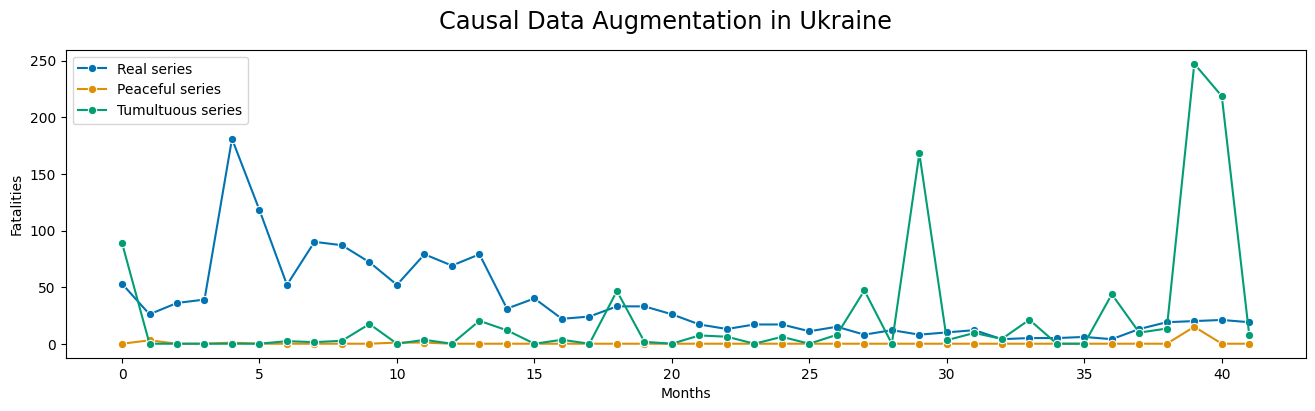

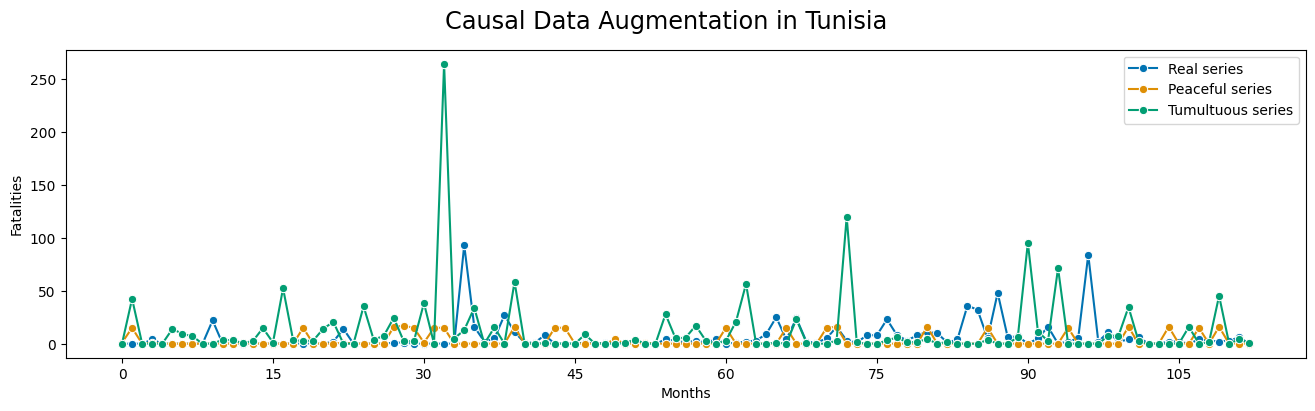

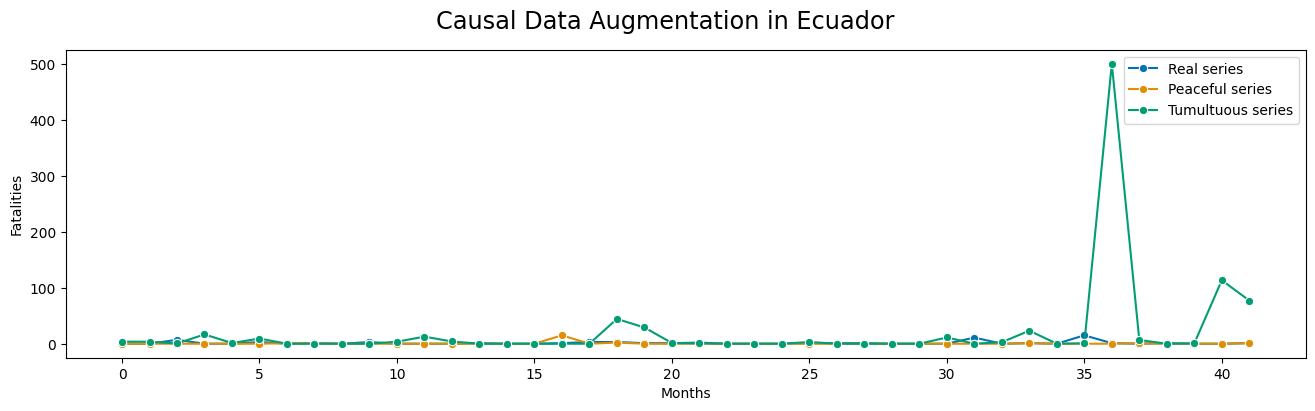

In [ ]:
from sktime.utils import plot_series

for c in target_countries:
    data_target = train_data.loc[train_data['country'] == c].copy().drop(columns=['country', time_col], axis=1)
    data_target = data_target.ffill().bfill()
    fatalities_real_target = data_target['Fatalities']
    fatalities_real_target.reset_index(drop=True, inplace=True)

    fatalities_peaceful_target = kernel.causal_data_augmentation(data_target, peaceful_domain.dropna().drop(['country', time_col], axis=1).copy().sample(500), causal_graph, 'Fatalities')['Fatalities'].clip(lower=0)
    fatalities_tumultuous_target = kernel.causal_data_augmentation(data_target, tumultuous_domain.dropna().drop(['country', time_col], axis=1).copy().sample(500), causal_graph, 'Fatalities')['Fatalities'].clip(lower=0)

    fig, ax = plot_series(fatalities_real_target, fatalities_peaceful_target, fatalities_tumultuous_target, labels=('Real series', 'Peaceful series', 'Tumultuous series'), x_label='Months', y_label='Fatalities', title=f'Causal Data Augmentation in {c}')
    fig.savefig(f'causal_data_augmentation_{c}.eps', format='eps')

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
from metrics import spike_precision, spike_recall
import pandas as pd
import re

scoring='neg_mean_absolute_error' # Change as needed

# Define the models and their respective hyperparameters for GridSearchCV
models = {
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 50],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 50],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(verbose=-1),
        'params': {
            'n_estimators': [100, 200, 50],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [-1, 5, 10]
        }
    }
}

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['Country', 'Data Type', 'Model', 'Best Parameters', 'Best Score'])

model_dict = {}

for cid, country in tqdm(enumerate(target_countries)):
    for model_name, model_info in models.items():
        
        data_original = train_data[train_data['country'] == country].copy().drop(columns=['country', time_col], axis=1)
        try:
            data_aug = train_data_aug[train_data_aug['country'] == country].copy().drop(columns=['country', time_col], axis=1)
        except:
            data_aug = train_data_aug[train_data_aug['country'] == country].copy().drop(columns=['country'], axis=1)


        x_val = val_data[val_data['country'] == country].copy().drop(columns=['country', time_col], axis=1)
        y_val = x_val[target]
        x_val = x_val.drop(columns=[target], axis=1)

        x_test = test_data[test_data['country'] == country].copy().drop(columns=['country', time_col], axis=1)
        y_test = x_test[target]
        x_test = x_test.drop(columns=[target], axis=1)

        for data_type, data in zip(['Original', 'Augmented'], [data_original, data_aug]):

            x_train = data.drop(columns=[target], axis=1)
            y_train = data[target]
            
            # Combine the training and validation sets
            X = pd.concat([x_train, x_val])
            y = pd.concat([y_train, y_val])

            # Create a list where train data indices are -1 and validation data indices are 0
            split_index = [-1 if x in x_train.index else 0 for x in X.index]

            # Create a PredefinedSplit
            pds = PredefinedSplit(test_fold = split_index)

            # Perform the grid search
            grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=pds, scoring=scoring)
            
            try:
                grid_search.fit(X, y)
            except:
                X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
                x_test = x_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
                grid_search.fit(X, y)

            y_pred = grid_search.predict(x_test).clip(min=0)
            mae = mean_absolute_error(y_test, y_pred)
            spike_prec = spike_precision(y_pred, y_test, 50, 20)
            spike_rec = spike_recall(y_pred, y_test, 50, 20)
            # Store the results
            results_row = pd.DataFrame({
                'Country': [country],
                'Data Type': [data_type],
                'Model': [model_name],
                'Best Parameters': [grid_search.best_params_],
                'Best Score': [grid_search.best_score_],
                'MAE': [mae],
                'Spike precision': spike_prec,
                'Spike recall': spike_rec
            })

            model_dict[f'{country}_{data_type}_{model_name}'] = grid_search.best_estimator_

            results = pd.concat([results, results_row], axis=0, ignore_index=True)

0it [00:00, ?it/s]

C:\Users\alber\AppData\Local\Temp\ipykernel_1144\3499453034.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, results_row], axis=0, ignore_index=True)
3it [01:02, 20.86s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


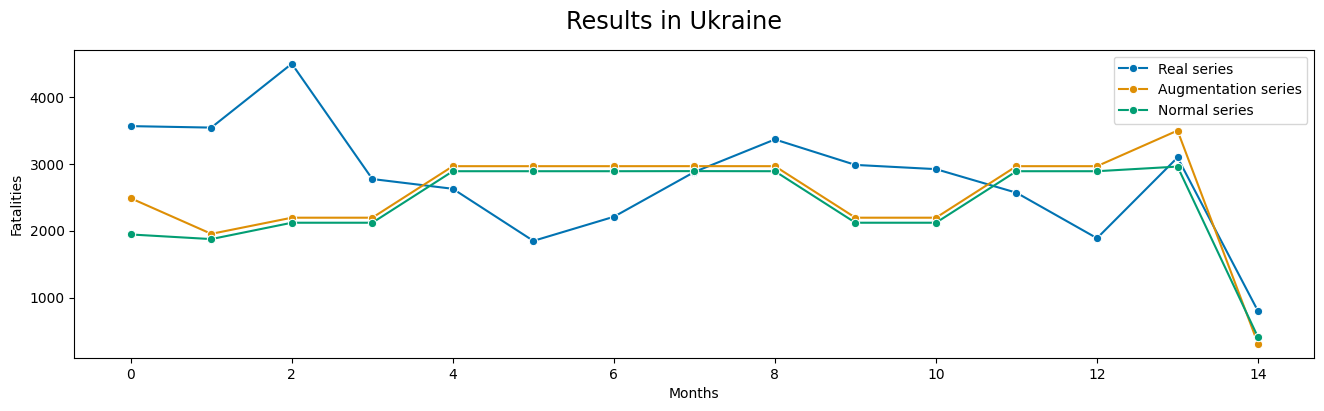

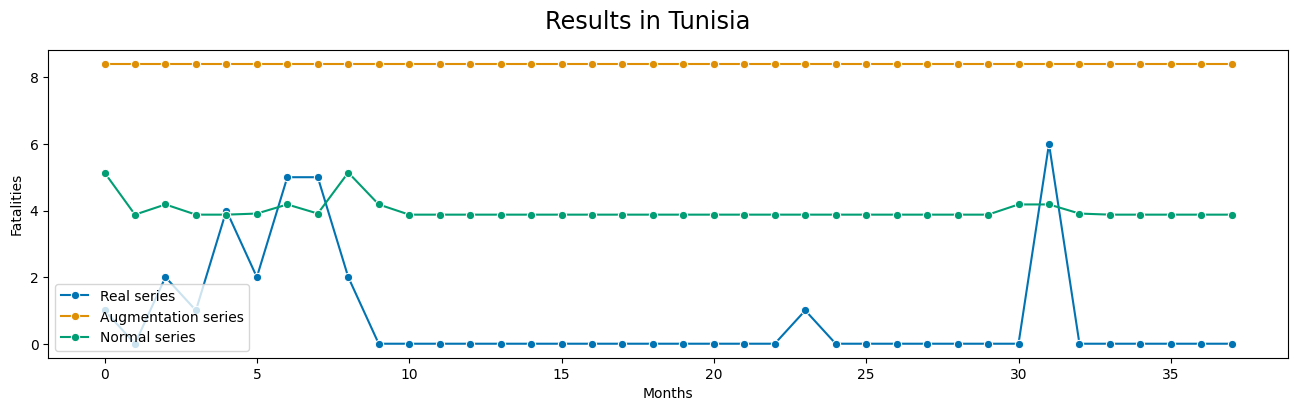

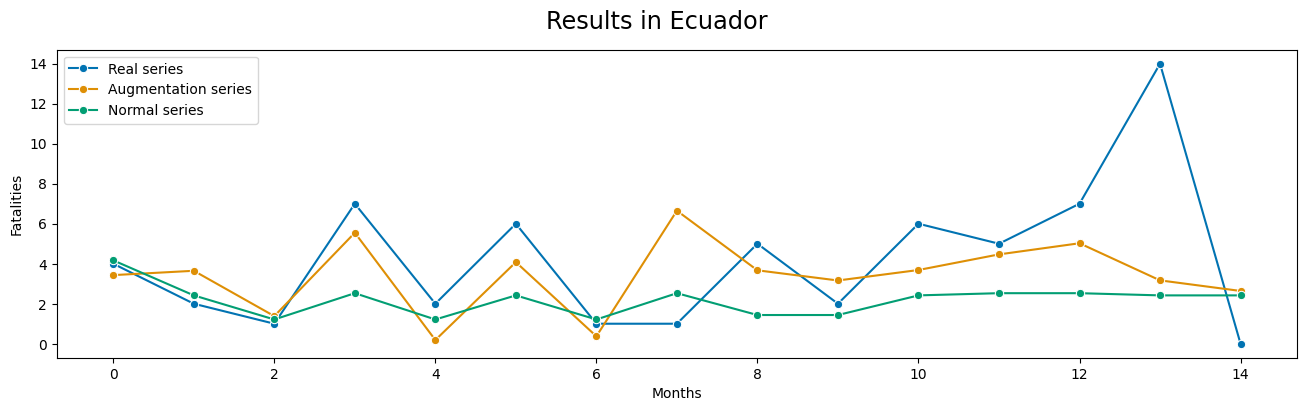

In [ ]:
from matplotlib import pyplot as plt

for c in target_countries:
    forecaster_aug = model_dict[f'{c}_Augmented_XGBoost']
    forecaster_original = model_dict[f'{c}_Original_XGBoost']

    x_test_target = test_data[test_data['country'] == c].copy().drop(columns=['country', time_col], axis=1)
    y_test_target = x_test_target[target]
    x_test_target = x_test_target.drop(columns=[target], axis=1)

    y_pred_target_aug = forecaster_aug.predict(x_test_target).clip(min=0)
    y_pred_target_original = forecaster_original.predict(x_test_target).clip(min=0)

    fig, ax = plot_series(pd.DataFrame(y_test_target.values), pd.DataFrame(y_pred_target_aug), pd.DataFrame(y_pred_target_original), labels=('Real series', 'Augmentation series', 'Normal series'), x_label='Months', y_label='Fatalities', title=f'Results in {c}')
    fig.savefig(f'results_{c}.eps', format='eps')

In [ ]:
results_targets = results.groupby(['Data Type', 'Model'])[['MAE', 'Spike precision', 'Spike recall']].mean().reset_index()
results_targets.to_csv('grid_search_results_targets.csv', index=False)
results_targets.round(2).to_latex('grid_search_results_targets.tex', index=False)

print(results_targets)

   Data Type         Model         MAE  Spike precision  Spike recall
0  Augmented      LightGBM  205.128147         0.666667      0.666667
1  Augmented  RandomForest  228.149676         0.666667      0.666667
2  Augmented       XGBoost  272.723738         0.666667      0.666667
3   Original      LightGBM  207.940187         0.688889      0.688889
4   Original  RandomForest  209.881272         0.688889      0.688889
5   Original       XGBoost  275.500837         0.688889      0.688889


In [ ]:
# Pivot the DataFrame to get 'Best Score' for 'Augmented' and 'Original' in the same row
pivot = results.pivot_table(index=['Country', 'Model'], columns='Data Type', values='MAE')

# Calculate a new column for whether 'Augmented' did better than 'Original'
pivot['Augmented Better'] = pivot['Augmented'] < pivot['Original']

# Reset the index to turn 'Country' and 'Model' back into columns
pivot = pivot.reset_index()

# Calculate the ratio of the number of countries that did better with 'Augmented' for each model
ratios = pivot.groupby('Model')['Augmented Better'].mean()

ratios.to_latex('grid_search_results_ratios.tex')

print(ratios)

Model
LightGBM        0.666667
RandomForest    0.000000
XGBoost         0.666667
Name: Augmented Better, dtype: float64
